# UCB Intro to Deep Learning, Week 4 Assignment - Kaggle competition on NLP Disaster Tweets

## GitHub link https://github.com/erikhel/UCB-DL-Class-Week-4

In [1]:
import keras
from keras import layers
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

from nltk.corpus import stopwords

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set(font_scale=1.5)
sns.set_style('white')
#plt.rcParams['figure.figsize']=(10,5)

# Step 1: Brief description of the problem and data

The task binary classification whether a tweet is about a real disaster (label 1) or not (label 0).

Data structure: Rows of
* [id] Tweet unique id
* [text] Tweet text
* [keyword] A tweet keyword, which may be blank (NaN)
* [location] Source location, which may be blank (NaN)
* [target] Label, 1: Disaster, 0: No disaster. Only in training data.

Data content:
* Training (labeled) data has 7613 tweets, which are between 7 and 157 characters in length. Keyword and location are null in, respectively, 61 and 2,533 tweets.
* Test (unlabeled) data has 3,262 tweets, which are between 5 and 151 characters in length. Keyword and location are null in, respectively, 26 and 1,105 tweets.
* So, we have a keyword most of the time (99% of tweets have non-null keyword) while location is mostly missing (33-34% of tweets have non-null keyword).

In [3]:
df_train = pd.read_csv('train.csv')
print(df_train.info())
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
print('Training: {} tweets between {} and {} length. Null keyword in {} tweets, null location in {} tweets.'.format(
          df_train.shape[0],
          df_train.text.str.len().min(),
          df_train.text.str.len().max(),
          df_train.keyword.isna().sum(),
          df_train.location.isna().sum()))

Training: 7613 tweets between 7 and 157 length. Null keyword in 61 tweets, null location in 2533 tweets.


In [5]:
df_test = pd.read_csv('test.csv')
print(df_test.info())
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
print('Test: {} tweets between {} and {} length. Null keyword in {} tweets, null location in {} tweets.'.format(
          df_test.shape[0],
          df_test.text.str.len().min(),
          df_test.text.str.len().max(),
          df_test.keyword.isna().sum(),
          df_test.location.isna().sum()))

Test: 3263 tweets between 5 and 151 length. Null keyword in 26 tweets, null location in 1105 tweets.


# Step 2: Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

Training data classes are fairly balanced (57%:43% for 0:1 labels). Tweet length distribution differ slightly between classes in that non-disaster tweets tend to be shorter. The peaks are close to the early tweet limit of 128 characters. The number of words are similary distributed across labels with a flat denisty around 10-20 words.

From previous section we know that all tweets (training and test) have nonzero length and there are null values in keyword (null prevalence 1%) and location (null prevalence 66-67%).

Considering these are real-world tweets, it can be expected that a lot of cleaning may be required. The following cleaning steps are performed here:
1. Remove duplicate tweets with inconsistent labels
2. Commonize case (e.g., lowercase) and remove punctuation (by keras preprocessing layer)

Cleaning should be done carefully not to destroy potentially useful information. For example, a common cleaning procedure is to take out common "stop words". However, that may destroy the meaning of the tweet. Using ntlk (demonstrate below), the sentence "there is no disaster here" turns into "disaster". Therefore, it was decided not to remover stop words.

Browsing Kaggle, there are many additional cleaning procedures that may be attempted. These were not pursued here for the sake of time. Some examples:
1. Remove numbers
2. Remove URLs 
3. Replace emojis with words or remove
4. Commonize abbreviations
5. Correct spelling
6. Stemming and lematization

## Inspect and visualize data

,Proportion %
target,
0,57.034021
1,42.965979


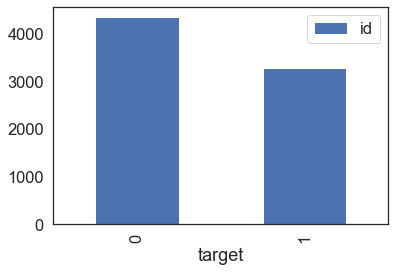

In [7]:
cats = df_train.target.unique()
ncats = len(cats)
df_count = df_train[['id','target']].groupby('target').count()
df_count.plot.bar()
(100*df_count/df_train.shape[0]).rename(columns={'id': 'Proportion %'})

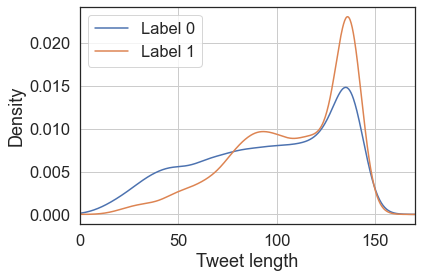

In [8]:
f,ax = plt.subplots()
for cat,df in df_train[['text','target']].groupby('target'):
    #df.text.str.len().hist(ax=ax,bins=np.arange(0,160,10), label=f'Label {cat}', alpha=0.5)
    df.text.str.len().plot.kde(ax=ax,label=f'Label {cat}')
plt.xlabel('Tweet length')
plt.xlim(0,170)
plt.legend(); plt.grid(); plt.show()

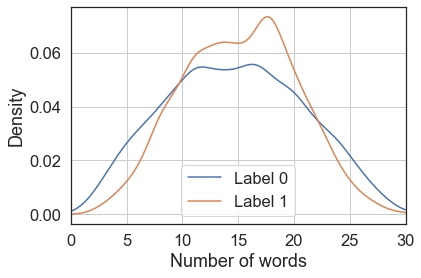

In [9]:
f,ax = plt.subplots()
for cat,df in df_train[['text','target']].groupby('target'):
    df.text.apply(lambda x: len(x.split())).plot.kde(ax=ax,label=f'Label {cat}')
plt.xlabel('Number of words')
plt.xlim(0,30)
plt.legend(); plt.grid(); plt.show()

## Remove duplicate tweets with inconsistent labels

In [10]:
df_dup = df_train[['text','target']].groupby('text').nunique()
df_dup = df_dup[df_dup.target > 1]

In [11]:
df_train[df_train.text == df_dup.index[0]]

,id,keyword,location,text,target
4290,6094,hellfire,"Jubail IC, Saudi Arabia.",#Allah describes piling up #wealth thinking it...,0
4299,6105,hellfire,?????? ??? ?????? ????????,#Allah describes piling up #wealth thinking it...,0
4312,6123,hellfire,?????? ???? ??????,#Allah describes piling up #wealth thinking it...,1


In [12]:
df_train.location.str.contains('\?').sum()

143

In [13]:
df_mislabeled = df_train.groupby(['text']).nunique().sort_values(by='target', ascending=False)
df_mislabeled = df_mislabeled[df_mislabeled['target'] > 1]['target']
df_train.loc[df_train.text.isin(df_mislabeled.index), 'target'] = np.nan
df_train.dropna(subset='target', inplace=True)
df_train.shape

(7558, 5)

## Stop words (keep them)

In [14]:
# Implementation adapted from [1]
stop_words = stopwords.words('english')
def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
#df_train['text_clean'] = df_train['text'].apply(remove_stopwords)
df_train['text_clean'] = df_train['text']

In [15]:
remove_stopwords('there is no disaster here')

'disaster'

In [16]:
df_train['text_clean']

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text_clean, Length: 7558, dtype: object

# Step 3: Model Architecture

The tweets are sequences of words and therefore recurrent type neural networks are candidate models. Here, bi-directional LSTMs are selected for their proven ability for NLP. Bi-directional LSTMs are more complex and slower than normal LSTM, but have the power to effectively combining LSTMs in forward and backward direction on a sentence enabling a better interpretation of a sentence (see, e.g., [2,3]).

The model archiecture is inspired from [2,4], an example in the Keras documentation for sentiment classification on IMDB movie reviews.

The model architecture is as follows: Text input -> Vectorize layer with vocabulary fit to training data -> Embedding layer to project the vocabulary indexes (positive integers) to a dense vector of fixed size -> 2 bi-directional LSTM layers -> a fully-connected layer with sigmoid activation for the classification. The vectorizing layer is an important step to decide on the size of the vocabulary and the sequence length to use. Vocabulary size was set to 20,000 from [2,4] while sequence length was limited to 30 considering the short nature of tweets (also see the EDA section above with the word length distributions).

Overfitting tendencies were noticed in first runs so regularization was added in form of dropouts (rate 0.6) and a batch normalization before the classifier output layer.

Two important design parameters remaining are embedding dimension and the number of LSTM units. These parameters are varied here between two levels and the results are compared. The table below summarizes the alternatives.

| Model# | Embed dim | LSTM units | #Param |
| -------|----------|-----|------|
| 1      | 32  | 32  |   681,697 |
| 2      | 64  | 32  | 1,329,921 |
| 3      | 32  | 64  |   788,897 |
| 4      | 64  | 64  | 1,445,313 |

In [17]:
# Vectorizer setup
MAX_FEAT = 20000 # Maximum size of the vocabulary
SEQ_LEN = 30     # output padded or truncated to exactly SEQ_LEN
EMB_DIM = 128//4 # for embedding to dense array in network
# Network setup
DROPOUT_RATE = 0.6
LSTM_UNITS = 64//2

#
# Vectorizer
#
vectorize_layer = TextVectorization(
    max_tokens = MAX_FEAT,
    standardize = 'lower_and_strip_punctuation',
    split = 'whitespace',
    ngrams = None,
    output_mode = 'int',
    output_sequence_length = SEQ_LEN,
)
vectorize_layer.adapt(df_train['text_clean'].values)
#vectorize_layer.get_vocabulary()

#
# Model 1
#
# Text input
inputs = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')
# Vectorize
x = vectorize_layer(inputs)
# Embedding
x = layers.Embedding(MAX_FEAT + 1, EMB_DIM)(x)
# 2 bidirectional LSTMs
x = layers.Bidirectional(layers.LSTM(LSTM_UNITS, return_sequences=True, dropout=DROPOUT_RATE, recurrent_dropout=DROPOUT_RATE))(x)
x = layers.Bidirectional(layers.LSTM(LSTM_UNITS, dropout=DROPOUT_RATE, recurrent_dropout=DROPOUT_RATE))(x)
x = layers.BatchNormalization()(x)
# Classifier
x = layers.Dropout(DROPOUT_RATE)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
# Complete model
model1 = keras.Model(inputs, outputs)
model1.summary()

2022-09-27 09:26:23.170905: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 30)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 30, 32)            640032    
                                                                 
 bidirectional (Bidirectiona  (None, 30, 64)           16640     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                             

In [18]:
# Vectorizer setup
MAX_FEAT = 20000 # Maximum size of the vocabulary
SEQ_LEN = 30     # output padded or truncated to exactly SEQ_LEN
EMB_DIM = 128//2 # for embedding to dense array in network
# Network setup
DROPOUT_RATE = 0.6
LSTM_UNITS = 64//2

#
# Vectorizer
#
vectorize_layer = TextVectorization(
    max_tokens = MAX_FEAT,
    standardize = 'lower_and_strip_punctuation',
    split = 'whitespace',
    ngrams = None,
    output_mode = 'int',
    output_sequence_length = SEQ_LEN,
)
vectorize_layer.adapt(df_train['text_clean'].values)
#vectorize_layer.get_vocabulary()

#
# Model 2
#
# Text input
inputs = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')
# Vectorize
x = vectorize_layer(inputs)
# Embedding
x = layers.Embedding(MAX_FEAT + 1, EMB_DIM)(x)
# 2 bidirectional LSTMs
x = layers.Bidirectional(layers.LSTM(LSTM_UNITS, return_sequences=True, dropout=DROPOUT_RATE, recurrent_dropout=DROPOUT_RATE))(x)
x = layers.Bidirectional(layers.LSTM(LSTM_UNITS, dropout=DROPOUT_RATE, recurrent_dropout=DROPOUT_RATE))(x)
x = layers.BatchNormalization()(x)
# Classifier
x = layers.Dropout(DROPOUT_RATE)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
# Complete model
model2 = keras.Model(inputs, outputs)
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 30)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 30, 64)            1280064   
                                                                 
 bidirectional_2 (Bidirectio  (None, 30, 64)           24832     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                           

In [19]:
# Vectorizer setup
MAX_FEAT = 20000 # Maximum size of the vocabulary
SEQ_LEN = 30     # output padded or truncated to exactly SEQ_LEN
EMB_DIM = 128//4 # for embedding to dense array in network
# Network setup
DROPOUT_RATE = 0.6
LSTM_UNITS = 64

#
# Vectorizer
#
vectorize_layer = TextVectorization(
    max_tokens = MAX_FEAT,
    standardize = 'lower_and_strip_punctuation',
    split = 'whitespace',
    ngrams = None,
    output_mode = 'int',
    output_sequence_length = SEQ_LEN,
)
vectorize_layer.adapt(df_train['text_clean'].values)
#vectorize_layer.get_vocabulary()

#
# Model 3
#
# Text input
inputs = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')
# Vectorize
x = vectorize_layer(inputs)
# Embedding
x = layers.Embedding(MAX_FEAT + 1, EMB_DIM)(x)
# 2 bidirectional LSTMs
x = layers.Bidirectional(layers.LSTM(LSTM_UNITS, return_sequences=True, dropout=DROPOUT_RATE, recurrent_dropout=DROPOUT_RATE))(x)
x = layers.Bidirectional(layers.LSTM(LSTM_UNITS, dropout=DROPOUT_RATE, recurrent_dropout=DROPOUT_RATE))(x)
x = layers.BatchNormalization()(x)
# Classifier
x = layers.Dropout(DROPOUT_RATE)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
# Complete model
model3 = keras.Model(inputs, outputs)
model3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 30)               0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 30, 32)            640032    
                                                                 
 bidirectional_4 (Bidirectio  (None, 30, 128)          49664     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                           

In [20]:
# Vectorizer setup
MAX_FEAT = 20000 # Maximum size of the vocabulary
SEQ_LEN = 30     # output padded or truncated to exactly SEQ_LEN
EMB_DIM = 128//2 # for embedding to dense array in network
# Network setup
DROPOUT_RATE = 0.6
LSTM_UNITS = 64

#
# Vectorizer
#
vectorize_layer = TextVectorization(
    max_tokens = MAX_FEAT,
    standardize = 'lower_and_strip_punctuation',
    split = 'whitespace',
    ngrams = None,
    output_mode = 'int',
    output_sequence_length = SEQ_LEN,
)
vectorize_layer.adapt(df_train['text_clean'].values)
#vectorize_layer.get_vocabulary()

#
# Model 4
#
# Text input
inputs = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')
# Vectorize
x = vectorize_layer(inputs)
# Embedding
x = layers.Embedding(MAX_FEAT + 1, EMB_DIM)(x)
# 2 bidirectional LSTMs
x = layers.Bidirectional(layers.LSTM(LSTM_UNITS, return_sequences=True, dropout=DROPOUT_RATE, recurrent_dropout=DROPOUT_RATE))(x)
x = layers.Bidirectional(layers.LSTM(LSTM_UNITS, dropout=DROPOUT_RATE, recurrent_dropout=DROPOUT_RATE))(x)
x = layers.BatchNormalization()(x)
# Classifier
x = layers.Dropout(DROPOUT_RATE)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
# Complete model
model4 = keras.Model(inputs, outputs)
model4.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 1)]               0         
                                                                 
 text_vectorization_3 (TextV  (None, 30)               0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 30, 64)            1280064   
                                                                 
 bidirectional_6 (Bidirectio  (None, 30, 128)          66048     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                           

# Step 4: Results and Analysis

The different architectures are trained and the results are compared. After some playing around with learning rate and epochs, the rate was set at 1e-4 and number of epochs to 8. The entire notebook was also run with removing stop words from the training data and the results were close and slightly lower. For the final results presented here, the stop words are therefore not removed.

From the results, presented in below figures, the following observations are made.
* The validation accuracy increases up close to 80% and flattens out after 5 epochs for all models, with some variations, where models start to show some  overfitting to varying degrees.
* The final valdation accuracy is similar and 79-80% for all models.
* The figure of validation accuracy versus number of parameters indicates that the gap between train and validation is similar for model 1 through 3 and larger for model 4, which has the most number of parameters. Model 2 and 3 have the highest validation accuracy but model 3 is relatively simpler with 59% less number of parameters.

In [21]:
RAND_SEED = 17
LEARNING_RATE = 1e-4
EPOCHS = 8

X = df_train.text_clean
y = df_train.target
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RAND_SEED)

model1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(name='accuracy')])
model2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(name='accuracy')])
model3.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(name='accuracy')])
model4.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(name='accuracy')])

In [22]:
model1_out = model1.fit(
    x = X_train,
    y = y_train,
    epochs = EPOCHS,
    validation_data = (X_val, y_val))

Epoch 1/8
189/189 [==============================] - 21s 68ms/step - loss: 0.7060 - accuracy: 0.5289 - val_loss: 0.6885 - val_accuracy: 0.5569
Epoch 2/8
189/189 [==============================] - 12s 63ms/step - loss: 0.6841 - accuracy: 0.5627 - val_loss: 0.6805 - val_accuracy: 0.5582
Epoch 3/8
189/189 [==============================] - 12s 61ms/step - loss: 0.6507 - accuracy: 0.6206 - val_loss: 0.6408 - val_accuracy: 0.7070
Epoch 4/8
189/189 [==============================] - 12s 64ms/step - loss: 0.5727 - accuracy: 0.7124 - val_loss: 0.5284 - val_accuracy: 0.7646
Epoch 5/8
189/189 [==============================] - 12s 62ms/step - loss: 0.4895 - accuracy: 0.7787 - val_loss: 0.5021 - val_accuracy: 0.7679
Epoch 6/8
189/189 [==============================] - 12s 62ms/step - loss: 0.4263 - accuracy: 0.8179 - val_loss: 0.4705 - val_accuracy: 0.7870
Epoch 7/8
189/189 [==============================] - 11s 61ms/step - loss: 0.3743 - accuracy: 0.8420 - val_loss: 0.4572 - val_accuracy: 0.7837

In [23]:
model2_out = model2.fit(
    x = X_train,
    y = y_train,
    epochs = EPOCHS,
    validation_data = (X_val, y_val))

Epoch 1/8
189/189 [==============================] - 21s 68ms/step - loss: 0.7148 - accuracy: 0.5367 - val_loss: 0.6872 - val_accuracy: 0.5569
Epoch 2/8
189/189 [==============================] - 12s 64ms/step - loss: 0.6805 - accuracy: 0.5741 - val_loss: 0.6733 - val_accuracy: 0.5787
Epoch 3/8
189/189 [==============================] - 12s 66ms/step - loss: 0.6200 - accuracy: 0.6550 - val_loss: 0.6147 - val_accuracy: 0.7315
Epoch 4/8
189/189 [==============================] - 13s 71ms/step - loss: 0.5420 - accuracy: 0.7344 - val_loss: 0.5204 - val_accuracy: 0.7672
Epoch 5/8
189/189 [==============================] - 13s 70ms/step - loss: 0.4685 - accuracy: 0.7880 - val_loss: 0.4792 - val_accuracy: 0.7864
Epoch 6/8
189/189 [==============================] - 13s 66ms/step - loss: 0.4159 - accuracy: 0.8243 - val_loss: 0.4711 - val_accuracy: 0.7983
Epoch 7/8
189/189 [==============================] - 13s 67ms/step - loss: 0.3565 - accuracy: 0.8563 - val_loss: 0.4829 - val_accuracy: 0.7923

In [24]:
model3_out = model3.fit(
    x = X_train,
    y = y_train,
    epochs = EPOCHS,
    validation_data = (X_val, y_val))

Epoch 1/8
189/189 [==============================] - 21s 70ms/step - loss: 0.7036 - accuracy: 0.5230 - val_loss: 0.6865 - val_accuracy: 0.5569
Epoch 2/8
189/189 [==============================] - 13s 70ms/step - loss: 0.6713 - accuracy: 0.5782 - val_loss: 0.6732 - val_accuracy: 0.5575
Epoch 3/8
189/189 [==============================] - 13s 70ms/step - loss: 0.6071 - accuracy: 0.6735 - val_loss: 0.5993 - val_accuracy: 0.7282
Epoch 4/8
189/189 [==============================] - 13s 70ms/step - loss: 0.5216 - accuracy: 0.7431 - val_loss: 0.5042 - val_accuracy: 0.7685
Epoch 5/8
189/189 [==============================] - 13s 68ms/step - loss: 0.4525 - accuracy: 0.7969 - val_loss: 0.4792 - val_accuracy: 0.7778
Epoch 6/8
189/189 [==============================] - 13s 68ms/step - loss: 0.3924 - accuracy: 0.8272 - val_loss: 0.5379 - val_accuracy: 0.7659
Epoch 7/8
189/189 [==============================] - 13s 68ms/step - loss: 0.3451 - accuracy: 0.8558 - val_loss: 0.4781 - val_accuracy: 0.7897

In [25]:
model4_out = model4.fit(
    x = X_train,
    y = y_train,
    epochs = EPOCHS,
    validation_data = (X_val, y_val))

Epoch 1/8
189/189 [==============================] - 22s 74ms/step - loss: 0.7161 - accuracy: 0.5354 - val_loss: 0.6844 - val_accuracy: 0.5569
Epoch 2/8
189/189 [==============================] - 13s 71ms/step - loss: 0.6655 - accuracy: 0.6037 - val_loss: 0.6606 - val_accuracy: 0.6204
Epoch 3/8
189/189 [==============================] - 14s 76ms/step - loss: 0.5733 - accuracy: 0.7071 - val_loss: 0.5619 - val_accuracy: 0.7685
Epoch 4/8
189/189 [==============================] - 14s 75ms/step - loss: 0.4802 - accuracy: 0.7812 - val_loss: 0.4774 - val_accuracy: 0.7831
Epoch 5/8
189/189 [==============================] - 14s 73ms/step - loss: 0.4222 - accuracy: 0.8159 - val_loss: 0.4581 - val_accuracy: 0.7837
Epoch 6/8
189/189 [==============================] - 14s 76ms/step - loss: 0.3649 - accuracy: 0.8477 - val_loss: 0.4554 - val_accuracy: 0.7956
Epoch 7/8
189/189 [==============================] - 14s 75ms/step - loss: 0.3041 - accuracy: 0.8707 - val_loss: 0.4813 - val_accuracy: 0.7917

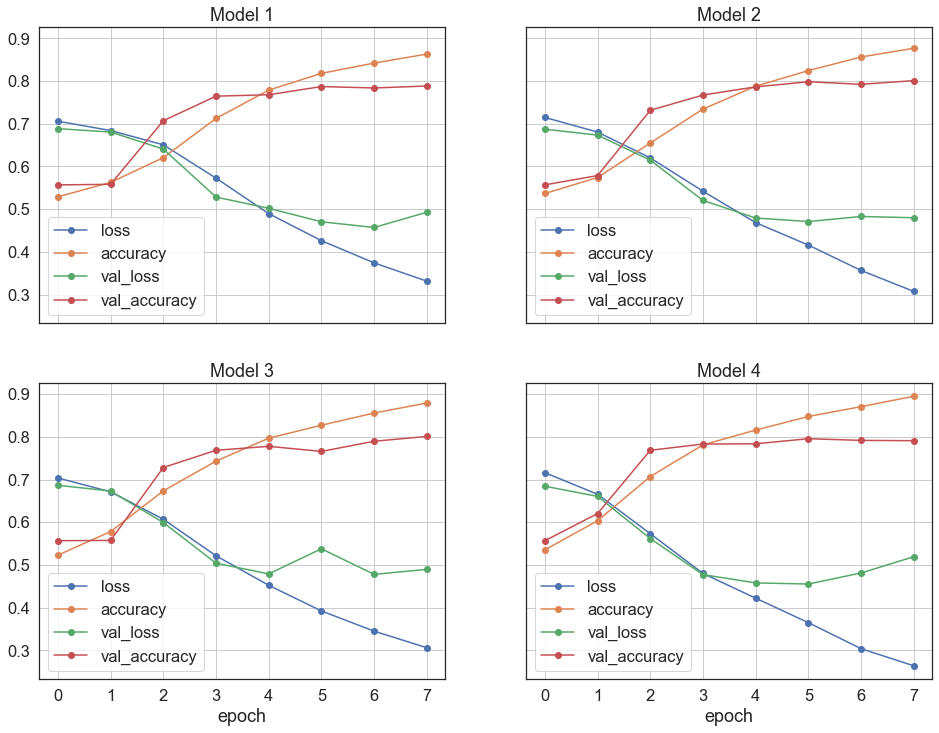

In [26]:
f,ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(16,12))
ax = ax.flatten()
for k in model1_out.history.keys():
    ax[0].plot(model1_out.history[k],'o-', label=k)
ax[0].set_title(f'Model 1'); 
for k in model2_out.history.keys():
    ax[1].plot(model2_out.history[k],'o-', label=k)
ax[1].set_title(f'Model 2');
for k in model3_out.history.keys():
    ax[2].plot(model3_out.history[k],'o-', label=k)
ax[2].set_title(f'Model 3');
for k in model4_out.history.keys():
    ax[3].plot(model4_out.history[k],'o-', label=k)
ax[3].set_title(f'Model 4');

ax[2].set_xlabel('epoch')
ax[3].set_xlabel('epoch')
for a in ax:
    a.legend()
    a.grid()

,no_param,train_accuracy_pct,val_accuracy_pct
0,681697,0.863050,0.788360
1,1329921,0.876778,0.800926
2,788897,0.879094,0.800926
3,1445313,0.894972,0.791005


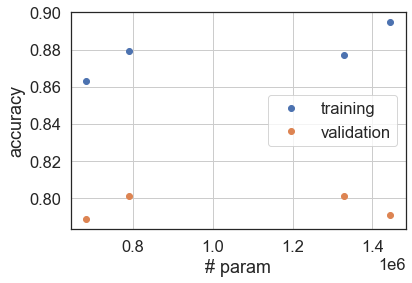

In [27]:
no_param = [keras.utils.layer_utils.count_params(x.trainable_weights) for x in [model1,model2,model3,model4]]
train_accuracy = [x.history['accuracy'][-1] for x in [model1_out,model2_out,model3_out,model4_out]]
val_accuracy = [x.history['val_accuracy'][-1] for x in [model1_out,model2_out,model3_out,model4_out]]
plt.plot(no_param, train_accuracy , 'o', label='training')
plt.plot(no_param, val_accuracy , 'o', label='validation')
plt.xlabel('# param'); plt.ylabel('accuracy')
plt.legend(); plt.grid();
pd.DataFrame({'no_param': no_param, 'train_accuracy_pct': train_accuracy,'val_accuracy_pct': val_accuracy})

# Step 5: Conclusion

The results are summarized in the figures above and the table below.

| Model# | Embed dim | LSTM units | #Param | Val accuracy % |
| -------|----------|-----|-----|--------|
| 1      | 32  | 32  |   681,697 | 78.9
| 2      | 64  | 32  | 1,329,921 | 80.0
| 3      | 32  | 64  |   788,897 | 80.0
| 4      | 64  | 64  | 1,445,313 | 79.1


The input data may be further cleaned and preprocessed. A number of possible cleaning steps were mentioned above. Additional alternatives (architectures) and further fine-tuning of hyper parameters may improve the results further. With the relatively small training data set, there may be a limit to the size of the models that may be trained from scratch. Transfer learning may therefore be an interesting avenue of further exploration (there are several Kaggle articles on this topic).

Model 3 was chosen in the end due to high validation accuracy and relatively fewer parameters (and smaller gap between training and validation scores) than model 2 with similar accuracy. The Kaggle score came back at 0.793.

## Make predictions on test data

In [28]:
pred_prob  = model3.predict(df_test.text).flatten()
pred_label = np.where(pred_prob > 0.5, 1, 0)

102/102 [==============================] - 2s 9ms/step


In [29]:
[pred_prob.mean(), pred_label.sum(), len(pred_label) - pred_label.sum()]

[0.3714729, 1069, 2194]

In [30]:
df_sub = pd.DataFrame({'id': df_test.id, 'target': pred_label}).set_index('id')
df_sub.to_csv('submission.csv', index=True)
df_sub

,target
id,
0,0
2,0
3,1
9,1
11,1
...,...
10861,1
10865,1
10868,1


# 6. References
1. https://www.kaggle.com/code/andreshg/nlp-glove-bert-tf-idf-lstm-explained
2. https://keras.io/examples/nlp/bidirectional_lstm_imdb/
3. https://www.baeldung.com/cs/bidirectional-vs-unidirectional-lstm
4. https://keras.io/examples/nlp/text_classification_from_scratch/